# Inverse Kinematics
---
The task is to solve the inverse kinematics problem using the learned Jacobian matrix. Since I only computed it for `r2` and `r3`, it follows that the IK will be solved only for these two.

In [76]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

print('Libraries imported.')

Libraries imported.


## Preparation

In [77]:
# Load models
r2 = tf.keras.models.load_model('fk_r2.keras')
r3 = tf.keras.models.load_model('fk_r3.keras')

# Initial guess
q_r2 = [0, 0]
q_r3 = [0, 0, 0]

# Forward kinematics functions
def forward_kinematics_r2(q):
    q = np.array([q], dtype=np.float32)
    return r2.predict(q, verbose=0)[0]

def forward_kinematics_r3(q):
    q = np.array([q], dtype=np.float32)
    return r3.predict(q, verbose=0)[0]

# Jacobian calculation functions
def Jacobian_r2(q):
    q = tf.Variable([q], dtype=tf.float32)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(q)
        y = r2(q)
    return np.reshape(tape.jacobian(y, q), (3, 2))

def Jacobian_r3(q):
    q = tf.Variable([q], dtype=tf.float32)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(q)
        y = r3(q)
    return np.reshape(tape.jacobian(y, q), (3, 3))

print('Test fk:')
fk_r2 = forward_kinematics_r2(q_r2)
fk_r3 = forward_kinematics_r3(q_r3)
print(f'[r2] End-effector pose for q=({q_r2[0]}, {q_r2[1]}): {fk_r2}')
print(f'[r3] End-effector pose for q=({q_r3[0]}, {q_r3[1]}, {q_r3[2]}): {fk_r3}')

print('\nTest J:')
J_r2 = Jacobian_r2(q_r2)
J_r3 = Jacobian_r3(q_r3)
print('J_r2 at home configuration:')
print(J_r2)
print('\nJ_r3 at home configuration:')
print(J_r3)

Test fk:
[r2] End-effector pose for q=(0, 0): [ 2.1526299e-01 -5.6490302e-05  1.9013971e-02]
[r3] End-effector pose for q=(0, 0, 0): [ 0.2692213  -0.0060422   0.04809026]

Test J:
J_r2 at home configuration:
[[0.07220468 0.05021465]
 [0.20301223 0.11655534]
 [1.0531076  1.0422575 ]]

J_r3 at home configuration:
[[ 0.12610109  0.08319021  0.02674973]
 [ 0.26530182  0.1854657  -0.00554005]
 [ 0.96138924  1.1172225   0.97341794]]


## 2R Planar robot

In [121]:
max_iterations = 100   # Maximum number of iterations
tolerance = 0.01      # Error threshold for convergence

def inverse_kinematics_r2(target_pose, initial_guess):
    lambda_val = 0.01 # Initial damping factor
    q = np.array(initial_guess, dtype=np.float32)
    for i in range(1, max_iterations+1):
        current_pose = forward_kinematics_r2(q)
        error = target_pose - current_pose
        error_norm = np.linalg.norm(error)
        if i % (max_iterations/10) == 0:
            print(f'########## Iteration {i} ##########')
            print(f'Current pose: {current_pose}')
            print(f'Error = {error_norm:.5f}')
        if np.linalg.norm(error) < tolerance:
            print(f'Converged in {i+1} iterations to {q}')
            print(f'Reached end-effector pose: {current_pose}')
            print(f'Original desired pose: {target_pose}')
            return q

        # Update rule
        J = Jacobian_r2(q)
        JTJ = J.T @ J + lambda_val*np.eye(J.shape[1]) # Regularized Jacobian
        delta_q = np.linalg.inv(JTJ) @ J.T @ error    # LM step

        # Tentative update
        q_new = q + delta_q
        new_error = np.linalg.norm(target_pose - forward_kinematics_r2(q_new))
        if new_error < error_norm:
            lambda_val /= 10 # Trust the step more
            q = q_new        # Accept the update
        else:
            lambda_val *= 10 # Trust the step less

    print(f'[r2] LM could not converge within {max_iterations} iterations')
    return q

In [80]:
l1, l2 = 0.1, 0.1
def plot_2r_robot(q):
    q1, q2 = q
    x0, y0 = 0, 0
    x1, y1 = l1*np.cos(q1), l1*np.sin(q1)
    x2, y2 = x1 + l2*np.cos(q1+q2), y1 + l2*np.sin(q1+q2)
    plt.figure(figsize=(6, 6))
    plt.plot([x0, x1], [y0, y1], '-o', label='Link 1', linewidth=4)
    plt.plot([x1, x2], [y1, y2], '-o', label='Link 2', linewidth=4)
    
    # Plot end-effector
    plt.plot(x2, y2, 'ro', label='End-Effector')
    
    # Set plot limits and labels
    plt.xlim(-0.25, 0.25)
    plt.ylim(-0.25, 0.25)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('[r2] "learned" Inverse kinematics')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

Converged in 6 iterations to [ 1.59035694 -1.59055929]
Reached end-effector pose: [ 9.99915302e-02  1.00118004e-01 -1.19209290e-05]
Original desired pose: [0.1 0.1 0. ]


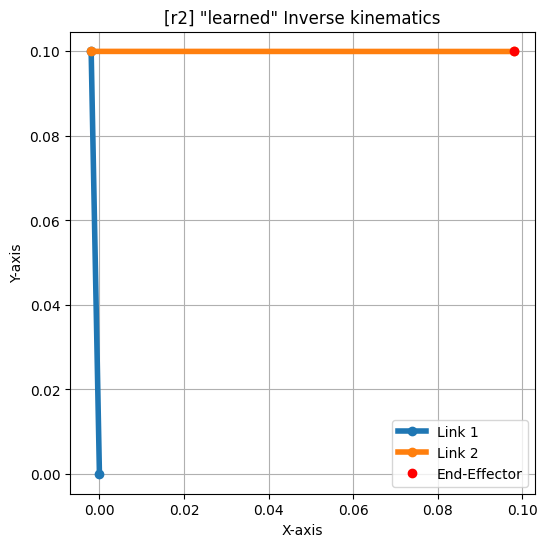

In [127]:
x_target, y_target, theta_target = 0.1, 0.1, 0.0
target_pose_r2 = np.array([x_target, y_target, theta_target])
initial_guess_r2 = [0.0, 0.0]

ik_r2 = inverse_kinematics_r2(target_pose_r2, initial_guess_r2)

plot_2r_robot(ik_r2)

########## Iteration 10 ##########
Current pose: [-3.5566464e-03 -1.4599599e-03  3.1414332e+00]
Error = 0.00385
########## Iteration 20 ##########
Current pose: [-3.5566464e-03 -1.4599599e-03  3.1414332e+00]
Error = 0.00385
########## Iteration 30 ##########
Current pose: [-3.5566464e-03 -1.4599599e-03  3.1414332e+00]
Error = 0.00385
########## Iteration 40 ##########
Current pose: [-3.5566464e-03 -1.4599599e-03  3.1414332e+00]
Error = 0.00385
########## Iteration 50 ##########
Current pose: [-3.5566464e-03 -1.4599599e-03  3.1414332e+00]
Error = 0.00385
########## Iteration 60 ##########
Current pose: [-3.5566464e-03 -1.4599599e-03  3.1414332e+00]
Error = 0.00385
########## Iteration 70 ##########
Current pose: [-3.5566464e-03 -1.4599599e-03  3.1414332e+00]
Error = 0.00385
########## Iteration 80 ##########
Current pose: [-3.5566464e-03 -1.4599599e-03  3.1414332e+00]
Error = 0.00385
########## Iteration 90 ##########
Current pose: [-3.5566464e-03 -1.4599599e-03  3.1414332e+00]
Error = 

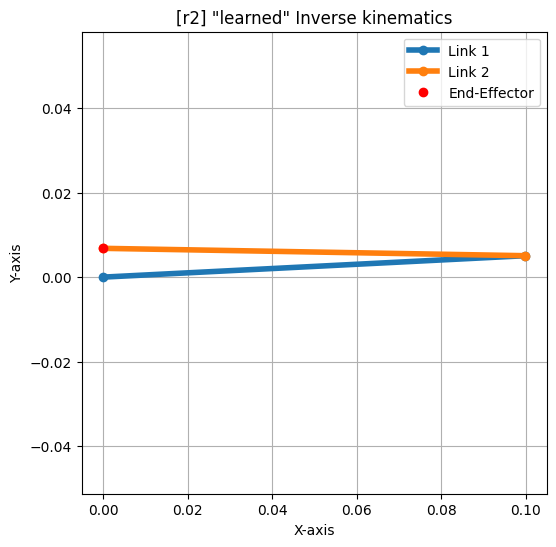

In [185]:
## retracted arm
x_target, y_target, theta_target = 0.0, 0.0, np.pi
target_pose_r2 = np.array([x_target, y_target, theta_target])
initial_guess_r2 = [0.0, 0.0]

ik_r2 = inverse_kinematics_r2(target_pose_r2, initial_guess_r2)

plot_2r_robot(ik_r2)

########## Iteration 1 ##########
Current pose: [ 2.1526299e-01 -5.6490302e-05  1.9013971e-02]
Error = 0.02438
########## Iteration 2 ##########
Current pose: [ 0.21409939 -0.00314526 -0.00025645]
Error = 0.01445
########## Iteration 3 ##########
Current pose: [ 0.21406956 -0.0032582  -0.00032476]
Error = 0.01445
########## Iteration 4 ##########
Current pose: [ 0.2140515  -0.00333105 -0.00031301]
Error = 0.01444
########## Iteration 5 ##########
Current pose: [ 0.2140383  -0.00338408 -0.00030401]
Error = 0.01444
########## Iteration 6 ##########
Current pose: [ 0.21402867 -0.0034227  -0.00029784]
Error = 0.01444
########## Iteration 7 ##########
Current pose: [ 0.21402173 -0.00345083 -0.00029293]
Error = 0.01444
########## Iteration 8 ##########
Current pose: [ 0.21401663 -0.00347136 -0.00028965]
Error = 0.01444
########## Iteration 9 ##########
Current pose: [ 0.2140129  -0.00348624 -0.00028688]
Error = 0.01444
########## Iteration 10 ##########
Current pose: [ 0.21401016 -0.00349715

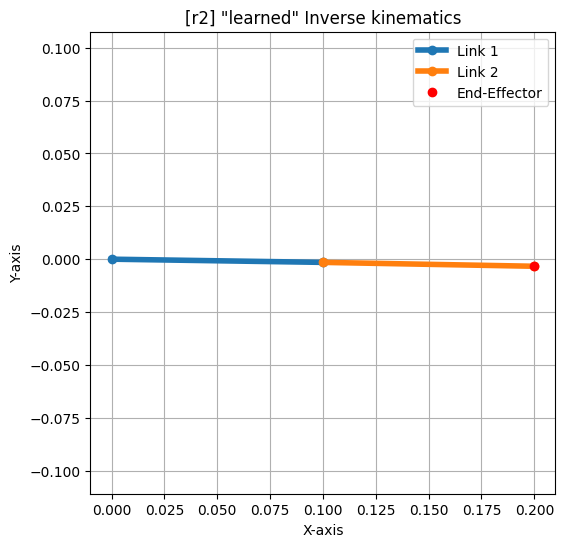

In [107]:
# out-stretched arm
x_target, y_target, theta_target = 0.2, 0.0, 0.0
target_pose_r2 = np.array([x_target, y_target, theta_target])
initial_guess_r2 = [0.0, 0.0]

ik_r2 = inverse_kinematics_r2(target_pose_r2, initial_guess_r2)

plot_2r_robot(ik_r2)

Converged in 4 iterations to [-0.13540012  1.68261588]
Reached end-effector pose: [0.09865406 0.08504328 1.5704286 ]
Original desired pose: [0.1        0.08       1.57079633]


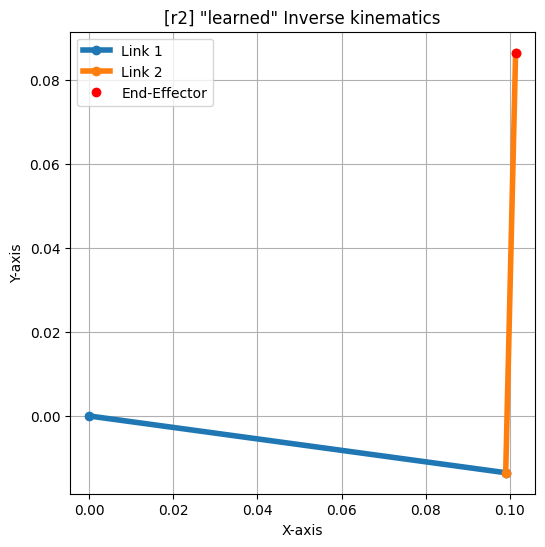

In [122]:
# Another random point for testing
x_target, y_target, theta_target = 0.1, 0.08, np.pi/2
target_pose_r2 = np.array([x_target, y_target, theta_target])
initial_guess_r2 = [0.0, 0.0]

ik_r2 = inverse_kinematics_r2(target_pose_r2, initial_guess_r2)

plot_2r_robot(ik_r2)

## 3R Planar robot

In [184]:
max_iterations = 100   # Maximum number of iterations
tolerance = 0.001      # Error threshold for convergence

def inverse_kinematics_r3(target_pose, initial_guess):
    lambda_val = 0.01 # Initial damping factor
    q = np.array(initial_guess, dtype=np.float32)
    for i in range(1, max_iterations+1):
        current_pose = forward_kinematics_r3(q)
        error = target_pose - current_pose
        error_norm = np.linalg.norm(error)
        if i % (max_iterations/10) == 0:
            print(f'########## Iteration {i} ##########')
            print(f'Current pose: {current_pose}')
            print(f'Error = {error_norm:.5f}')
        if np.linalg.norm(error) < tolerance:
            print(f'Converged in {i+1} iterations to q={q}')
            print(f'Reached end-effector pose: {current_pose}')
            print(f'Original desired pose: {target_pose}')
            return q

        # Update rule
        J = Jacobian_r3(q)
        JTJ = J.T @ J + lambda_val*np.eye(J.shape[1]) # Regularized Jacobian
        delta_q = np.linalg.inv(JTJ) @ J.T @ error    # LM step

        # Tentative update
        q_new = q + delta_q
        new_error = np.linalg.norm(target_pose - forward_kinematics_r3(q_new))
        if new_error < error_norm:
            lambda_val /= 10 # Trust the step more
            q = q_new        # Accept the update
        else:
            lambda_val *= 10 # Trust the step less

    print(f'[r3] LM could not converge within {max_iterations} iterations')
    return q

In [168]:
l1, l2, l3 = 0.1, 0.1, 0.1
def plot_3r_robot(q):
    q1, q2, q3 = q
    x0, y0 = 0, 0
    x1, y1 = l1*np.cos(q1), l1*np.sin(q1)
    x2, y2 = x1 + l2*np.cos(q1+q2), y1 + l2*np.sin(q1+q2)
    x3, y3 = x2 + l3*np.cos(q1+q2+q3), y2 + l3*np.sin(q1+q2+q3)
    plt.figure(figsize=(6, 6))
    plt.plot([x0, x1], [y0, y1], '-o', label='Link 1', linewidth=4)
    plt.plot([x1, x2], [y1, y2], '-o', label='Link 2', linewidth=4)
    plt.plot([x2, x3], [y2, y3], '-o', label='Link 3', linewidth=4)
    
    # Plot end-effector
    plt.plot(x3, y3, 'ro', label='End-Effector')
    
    # Set plot limits and labels
    plt.xlim(-0.35, 0.35)
    plt.ylim(-0.35, 0.35)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('[r3] "learned" Inverse kinematics')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

########## Iteration 10 ##########
Current pose: [2.7731207e-01 1.1120364e-02 6.1437488e-05]
Error = 0.02527
Converged in 18 iterations to q=[ 0.22587197 -0.44470088  0.23164519]
Reached end-effector pose: [ 2.9840493e-01  1.3950914e-03 -8.7514520e-05]
Original desired pose: [0.3 0.  0. ]


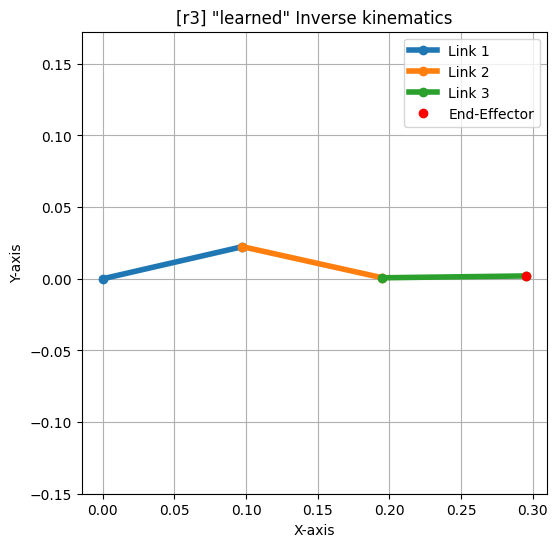

In [173]:
x_target, y_target, theta_target = 0.3, 0.0, 0.0
target_pose_r3 = np.array([x_target, y_target, theta_target])
initial_guess_r3 = [0.0, 0.0, 0.0]

ik_r3 = inverse_kinematics_r3(target_pose_r3, initial_guess_r3)

plot_3r_robot(ik_r3)

Converged in 6 iterations to q=[0.46765688 0.14954817 0.1176435 ]
Reached end-effector pose: [0.2500029  0.15000294 0.7853933 ]
Original desired pose: [0.25       0.15       0.78539816]


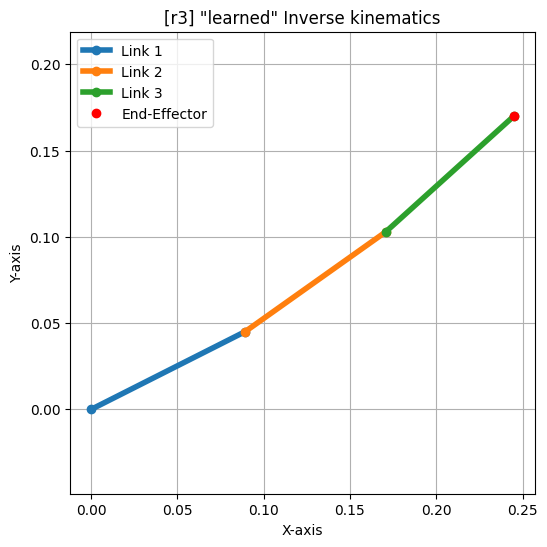

In [183]:
x_target, y_target, theta_target = 0.25, 0.15, np.pi/4
target_pose_r3 = np.array([x_target, y_target, theta_target])
initial_guess_r3 = [0.0, 0.0, 0.0]

ik_r3 = inverse_kinematics_r3(target_pose_r3, initial_guess_r3)

plot_3r_robot(ik_r3)